Colab で動かす場合、ランタイムを GPU にしてください。

# はじめに


ハイブリッド方策は、モデルベースとモデルフリー方策を併用して行動選択を行う方法です。

<div style="text-align: center">
<img width="450" alt="tdmpc.png (101.7 kB)" src="https://img.esa.io/uploads/production/attachments/21189/2024/01/17/160121/3ec0c7fd-c365-430b-816d-1be1c9bce83d.png">
</div>

ハイブリッド方策の実装は、ここまでに実装した以下の内容をベースに作成しています。
- [モデルベース方策の実装例](https://proxima-ai-tech-arbeit.esa.io/posts/23)
-  [モデルフリー方策の実装例](https://proxima-ai-tech-arbeit.esa.io/posts/22)

# 実装
### ライブラリの準備

In [ ]:
# ライブラリのインストール
!pip install brax -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.0/690.0 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 18.5 MB/s eta 0:00:00


In [ ]:
# ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax

from IPython.display import HTML, clear_output
from tqdm.notebook import tqdm
from flax.linen.initializers import constant, orthogonal
from flax.training.train_state import TrainState
from brax import envs
from brax.io import html

# 乱数のシードを設定
key = jax.random.PRNGKey(42)

### 環境の定義

In [ ]:
env = envs.get_environment(env_name='halfcheetah', backend='positional')
episode_length = 200

# コンパイル設定
env_reset = jax.jit(env.reset)
env_step = jax.jit(env.step)

# 状態と行動の次元を取得
obs_dim = env.observation_size
action_dim = env.action_size

print(f"obs_dim: {obs_dim}, action_dim: {action_dim}")

obs_dim: 17, action_dim: 6


In [ ]:
# モデル学習用のハイパーパラメータ
rho = 0.5
learning_rate = 0.001
total_timesteps = 50000
learning_starts = 5000
batch_size = 512
gamma = 0.99
tau = 0.05
grad_clip_norm = 10.0

# MPPI のハイパーパラメータ
horizon = 5
iterations = 6
num_samples = 512
num_actor_traj = 16
num_elites = 64
temperature = 0.25

### モデルの定義

In [ ]:
class Dynamics(nn.Module):
    obs_dim: int

    @nn.compact
    def __call__(self, obs, action):
        x = jnp.concatenate([obs, action], -1)
        x = nn.Dense(256, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(256, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(self.obs_dim)(x)
        return x


class Reward(nn.Module):
    @nn.compact
    def __call__(self, obs, action):
        x = jnp.concatenate([obs, action], -1)
        x = nn.Dense(256, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(256, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(1, kernel_init=orthogonal(1e-5), bias_init=constant(0))(x)
        return x


class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, obs):
        x = nn.Dense(64, kernel_init=orthogonal(1), bias_init=constant(0))(obs)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(64, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(self.action_dim, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.tanh(x)
        return x


class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, obs, action):
        x = jnp.concatenate([obs, action], -1)
        x = nn.Dense(64, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(64, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(1, kernel_init=orthogonal(1e-5), bias_init=constant(0))(x)
        return x


# モデルの定義
dynamics = Dynamics(obs_dim)
reward_fn = Reward()
actor = Actor(action_dim)
qf = QNetwork()

# コンパイル設定
dynamics.apply = jax.jit(dynamics.apply)
reward_fn.apply = jax.jit(reward_fn.apply)
actor.apply = jax.jit(actor.apply)
qf.apply = jax.jit(qf.apply)

class TrainState(TrainState):
    target_params: flax.core.FrozenDict


key, dynamics_key, reward_key, actor_key, qf1_key, qf2_key = jax.random.split(key, 6)

dynamics_state = TrainState.create(
    apply_fn = dynamics.apply,
    params = dynamics.init(dynamics_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    target_params = None,
    tx = optax.chain(
        optax.clip_by_global_norm(grad_clip_norm),
        optax.adam(learning_rate=learning_rate)
    )
)

reward_state = TrainState.create(
    apply_fn = reward_fn.apply,
    params = reward_fn.init(reward_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    target_params = None,
    tx = optax.chain(
        optax.clip_by_global_norm(grad_clip_norm),
        optax.adam(learning_rate=learning_rate)
    )
)

actor_state = TrainState.create(
    apply_fn = actor.apply,
    params = actor.init(actor_key, jnp.ones(obs_dim)),
    target_params = None,
    tx = optax.chain(
        optax.clip_by_global_norm(grad_clip_norm),
        optax.adam(learning_rate=learning_rate)
    )
)

qf1_state = TrainState.create(
    apply_fn = qf.apply,
    params = qf.init(qf1_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    target_params = qf.init(qf1_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    tx = optax.chain(
        optax.clip_by_global_norm(grad_clip_norm),
        optax.adam(learning_rate=learning_rate)
    )
)

qf2_state = TrainState.create(
    apply_fn = qf.apply,
    params = qf.init(qf2_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    target_params = qf.init(qf2_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    tx = optax.chain(
        optax.clip_by_global_norm(grad_clip_norm),
        optax.adam(learning_rate=learning_rate)
    )
)

### リプレイバッファ

In [ ]:
class ReplayBuffer():

    def __init__(self, total_timesteps, episode_length, obs_dim, action_dim):

        # バッファの定義
        num_episode = (total_timesteps // episode_length) + 1
        self.obs_buffer = np.empty((num_episode, episode_length + 1, obs_dim), dtype=np.float32)
        self.action_buffer = np.empty((num_episode, episode_length, action_dim), dtype=np.float32)
        self.reward_buffer = np.empty((num_episode, episode_length, 1), dtype=np.float32)

        self.episode_length = episode_length
        self.iter = 0


    def add(self, obss, actions, rewards):

        # バッファにシーケンスを格納
        self.obs_buffer[self.iter] = obss
        self.action_buffer[self.iter] = actions
        self.reward_buffer[self.iter] = rewards[:, None]
        self.iter += 1


    def sample(self, batch_size, horizon):

        # バッファから取得する要素の index をサンプリング
        idx = np.random.randint(self.iter, size=batch_size)
        idy = np.random.randint(self.episode_length - horizon, size=batch_size)

        obs_dim = self.obs_buffer.shape[2]
        action_dim = self.action_buffer.shape[2]

        # バッファからデータを取得
        obss = np.empty((horizon+1, batch_size, obs_dim), dtype=np.float32)
        actions = np.empty((horizon, batch_size, action_dim), dtype=np.float32)
        rewards = np.empty((horizon, batch_size, 1), dtype=np.float32)
        for t in range(horizon):
            obss[t] = self.obs_buffer[idx, idy+t]
            actions[t] = self.action_buffer[idx, idy+t]
            rewards[t] = self.reward_buffer[idx, idy+t]
        obss[horizon] = self.obs_buffer[idx, idy+horizon]
        return jnp.array(obss), jnp.array(actions), jnp.array(rewards)

rb = ReplayBuffer(total_timesteps, episode_length, obs_dim, action_dim)

### 学習用関数

In [ ]:
@jax.jit
def update_dynamics(
    dynamics_state,
    reward_state,
    obss,
    actions,
    rewards,
):

    def loss_fn(dynamics_params, reward_params):

        def rollout(obs, action):
            obs_pred = dynamics.apply(dynamics_params, obs, action)
            reward_pred = reward_fn.apply(reward_params, obs, action)
            return obs_pred, (obs_pred, reward_pred)

        # 環境モデルによる予測値を計算
        _, (obss_pred, rewards_pred) = jax.lax.scan(rollout, obss[0], actions)

        # 直近の誤差を重視するための係数
        rhos = rho ** jnp.arange(horizon)
        rhos = jnp.expand_dims(rhos, axis=(1,2))

        # 二乗和誤差の計算
        transition_loss = jnp.mean(rhos * (obss[1:] - obss_pred) ** 2)
        reward_loss = jnp.mean(rhos * (rewards - rewards_pred) ** 2)

        return transition_loss + reward_loss

    # 勾配を計算
    grad_fn = jax.value_and_grad(loss_fn, argnums=(0,1))
    loss_value, grads = grad_fn(dynamics_state.params, reward_state.params)

    # パラメータを更新
    dynamics_state = dynamics_state.apply_gradients(grads=grads[0])
    reward_state = reward_state.apply_gradients(grads=grads[1])
    return dynamics_state, reward_state, loss_value


@jax.jit
def update_critic(
    actor_state,
    qf1_state,
    qf2_state,
    obss,
    actions,
    rewards,
):

    # ターゲットの計算
    def calc_target_value(next_obs, reward):
        next_action = actor.apply(actor_state.params, next_obs)
        qf1_next_target = qf.apply(qf1_state.target_params, next_obs, next_action)
        qf2_next_target = qf.apply(qf2_state.target_params, next_obs, next_action)
        min_qf_next_target = jnp.minimum(qf1_next_target, qf2_next_target)
        qf_target = reward + gamma * min_qf_next_target
        return qf_target

    qf_targets = jax.vmap(calc_target_value)(obss[1:], rewards)

    rhos = rho ** jnp.arange(horizon)

    def loss_fn(qf1_params, qf2_params):
        qf_vmap = jax.vmap(qf.apply, in_axes=(None, 0, 0))
        qf1_values = qf_vmap(qf1_params, obss[:-1], actions)
        qf2_values = qf_vmap(qf2_params, obss[:-1], actions)
        value_loss1 = jnp.mean(rhos * (qf1_values - qf_targets)**2)
        value_loss2 = jnp.mean(rhos * (qf2_values - qf_targets)**2)
        return value_loss1 + value_loss2

    # 勾配を計算
    grad_fn = jax.value_and_grad(loss_fn, argnums=(0,1))
    loss_value, grads = grad_fn(qf1_state.params, qf2_state.params)

    # パラメータを更新
    qf1_state = qf1_state.apply_gradients(grads=grads[0])
    qf2_state = qf2_state.apply_gradients(grads=grads[1])

    # パラメータの移動平均を計算
    qf1_state = qf1_state.replace(target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, tau))
    qf2_state = qf2_state.replace(target_params=optax.incremental_update(qf2_state.params, qf2_state.target_params, tau))

    return qf1_state, qf2_state, loss_value


@jax.jit
def update_actor(
    actor_state,
    qf1_state,
    qf2_state,
    obss,
):

    # 誤差関数
    def loss_fn(params):
        def one_step_loss(obs):
            actions = actor.apply(params, obs)
            qf1_value = qf.apply(qf1_state.params, obs, actions)
            qf2_value = qf.apply(qf2_state.params, obs, actions)
            min_qf_value = jnp.minimum(qf1_value, qf2_value)
            return - jnp.mean(min_qf_value)

        rhos = rho ** jnp.arange(horizon+1)
        actor_loss_sequence = jax.vmap(one_step_loss)(obss)
        return jnp.mean(rhos * actor_loss_sequence)

    # 勾配を計算
    loss_value, grads = jax.value_and_grad(loss_fn)(actor_state.params)

    # パラメータを更新
    actor_state = actor_state.apply_gradients(grads=grads)

    return actor_state, loss_value


### MPPI 関数

In [ ]:
@jax.jit
def mppi_with_model(
    key,
    obs_init,
    dynamics_state,
    reward_state,
    actor_state,
    qf1_state,
    qf2_state,
    actions_mean,
    exploration_std,
):

    def get_actor_action_sequence(key):
        def scan_fn(obs, key):
            action = actor.apply(actor_state.params, obs)
            eps = jax.random.normal(key, (num_actor_traj, action_dim))
            action = action + exploration_std * eps
            action = jnp.clip(action, -1.0, 1.0)
            obs_pred = dynamics.apply(dynamics_state.params, obs, action)
            return obs_pred, action

        keys = jax.random.split(key, horizon)
        obs_init_batch = jnp.repeat(obs_init[None], num_actor_traj, axis=0)
        _, actions_batch = jax.lax.scan(scan_fn, obs_init_batch, keys)
        actions_batch = jnp.transpose(actions_batch, (1, 0, 2))
        return actions_batch

    key, subkey = jax.random.split(key)
    action_actor_batch = get_actor_action_sequence(subkey)


    def sample_action_sequence(key, actions_mean, actions_std):
        eps = jax.random.normal(key, (num_samples, horizon, action_dim))
        actions_batch = actions_mean[None] + actions_std[None] * eps
        actions_batch = jnp.clip(actions_batch, -1.0, 1.0)
        return actions_batch


    def compute_return(obs, actions):
        def rollout(carry, action):
            obs, discount = carry
            next_obs = dynamics.apply(dynamics_state.params, obs, action)
            reward = reward_fn.apply(reward_state.params, obs, action)
            return (next_obs, gamma*discount), discount*reward

        (obs_last, discount), rewards = jax.lax.scan(rollout, (obs, 1.0), actions)
        action = actor.apply(actor_state.params, obs_last)
        qf1_value = qf.apply(qf1_state.params, obs_last, action).squeeze()
        qf2_value = qf.apply(qf2_state.params, obs_last, action).squeeze()
        V = jnp.sum(rewards) + discount * jnp.minimum(qf1_value, qf2_value)
        return V


    def get_elite(key, actions_mean, actions_std):

        # 行動シーケンスをサンプリング
        key, subkey = jax.random.split(key)
        actions_batch = jnp.concatenate([
            sample_action_sequence(subkey, actions_mean, actions_std),
            action_actor_batch,
        ])
        actions_batch = sample_action_sequence(subkey, actions_mean, actions_std)

        # 行動シーケンスの報酬和を評価
        V_func = lambda actions: compute_return(obs_init, actions)
        V_batch = jax.vmap(V_func)(actions_batch)

        # 報酬和をもとにエリートを選択
        V_elite, elite_index = jax.lax.top_k(V_batch, num_elites)
        actions_elite = actions_batch[elite_index]

        return V_elite, actions_elite


    def update_params(mean, std, V_elite, actions_elite):

        score = jnp.exp(temperature * (V_elite - jnp.max(V_elite)))
        score = score[:, None, None] / (jnp.sum(score) + 1e-9)

        mean = jnp.sum(score * actions_elite, axis=0)
        std = jnp.sqrt(jnp.sum(score * (actions_elite - mean[None])**2, axis=0))
        return mean, std


    def body_fun(_, val):
        key, actions_mean, actions_std = val

        # サンプル分布からエリートを取得
        key, subkey = jax.random.split(key)
        V_elite, actions_elite = get_elite(subkey, actions_mean, actions_std)

        # サンプル分布のパラメータを更新
        actions_mean, actions_std \
            = update_params(actions_mean, actions_std, V_elite, actions_elite)

        return (key, actions_mean, actions_std)


    # サンプル分布の標準偏差を初期化
    actions_std = jnp.ones((horizon, action_dim))

    # MPPI のループを実行
    init_val = (key, actions_mean, actions_std)
    val = jax.lax.fori_loop(0, iterations, body_fun, init_val)
    key, actions_mean, actions_std = val

    # サンプル分布からエリートを取得
    key, subkey = jax.random.split(key)
    V_elite, actions_elite = get_elite(subkey, actions_mean, actions_std)

    # 最良の行動シーケンスの先頭の行動を取得
    action_best = actions_elite[jnp.argmax(V_elite), 0]

    # 探索を促進するためのノイズを印加
    eps = jax.random.normal(key, (action_dim, ))
    action_best = action_best + exploration_std * eps
    action_best = jnp.clip(action_best, -1.0, 1.0)

    return action_best, actions_mean

### データ収集用関数

In [ ]:
@jax.jit
def random_rollout(key):
    def body_fun(env_state, key):
        action = jax.random.uniform(key, (action_dim,), minval=-1.0, maxval=1.0)
        env_state = env_step(env_state, action)
        return env_state, (env_state.obs, action, env_state.reward)

    # 環境の初期化
    key, subkey = jax.random.split(key)
    env_state = env_reset(subkey)
    init_obs = env_state.obs[None]

    # ロールアウトを実行
    keys = jax.random.split(key, episode_length)
    _, (obss, actions, rewards) = jax.lax.scan(body_fun, env_state, keys)

    obss = jnp.concatenate([init_obs, obss], axis=0)
    return obss, actions, rewards


@jax.jit
def policy_rollout(key, dynamics_state, reward_state, actor_state, qf1_state, qf2_state):

    def body_fun(carry, key):
        actions_mean, env_state = carry

        action, actions_mean = mppi_with_model(
            key,
            env_state.obs,
            dynamics_state,
            reward_state,
            actor_state,
            qf1_state,
            qf2_state,
            actions_mean,
            exploration_std=0.1
        )
        env_state = env_step(env_state, action)
        obs, reward = env_state.obs, env_state.reward
        actions_mean = jnp.concatenate([actions_mean[1:], jnp.zeros((1, action_dim))])
        return (actions_mean, env_state), (obs, action, reward)

    # 環境の初期化
    key, subkey = jax.random.split(key)
    env_state = env_reset(subkey)
    init_obs = env_state.obs[None]

    # ロールアウトを実行
    keys = jax.random.split(key, episode_length)
    actions_mean = jnp.zeros((horizon, action_dim))
    _, (obss, actions, rewards) = jax.lax.scan(body_fun, (actions_mean, env_state), keys)

    obss = jnp.concatenate([init_obs, obss], axis=0)
    return obss, actions, rewards

### 学習の実行

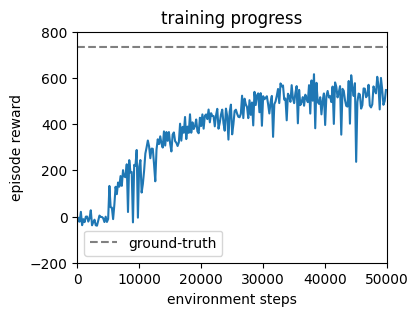

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
xdata, ydata = [], []
def progress(global_step, episodic_return):
    xdata.append(global_step)
    ydata.append(episodic_return)
    clear_output(wait=True)
    plt.figure(figsize=(4,3))
    plt.plot(xdata, ydata)

    # モデルベース方策の結果
    sim_reward_sum = 733.9458618164062
    xs = np.arange(total_timesteps)
    ys = np.ones((total_timesteps,)) * sim_reward_sum
    plt.plot(xs, ys, color="gray", linestyle="--", label="ground-truth")
    plt.legend()

    plt.xlim([0, total_timesteps])
    plt.ylim([-200, 800])
    plt.xlabel('environment steps')
    plt.ylabel('episode reward')
    plt.title('training progress')
    plt.show()


steps_log = []
rewards_log = []

for global_step in range(0, total_timesteps, episode_length):

    if global_step <= learning_starts:
        key, subkey = jax.random.split(key)
        obss, actions, rewards = random_rollout(subkey)

    else:
        key, subkey = jax.random.split(key)
        obss, actions, rewards = policy_rollout(subkey, dynamics_state, reward_state, actor_state, qf1_state, qf2_state)

    rb.add(obss, actions, rewards)
    episodic_return = np.sum(rewards)
    progress(global_step, episodic_return)

    train_metrics = {}
    if global_step >= learning_starts:
        num_updates = learning_starts if global_step == learning_starts else episode_length
        for i in tqdm(range(num_updates)):

            # バッファからサンプルを取得
            samples = rb.sample(batch_size, horizon)

            # 環境モデルを更新
            dynamics_state, reward_state, dynamics_loss_value = update_dynamics(dynamics_state, reward_state, *samples)

            qf1_state, qf2_state, critic_loss_value = update_critic(actor_state, qf1_state, qf2_state, *samples)

            # アクターを更新
            obss = samples[0]
            actor_state, actor_loss_value = update_actor(actor_state, qf1_state, qf2_state, obss)

### 学習結果の可視化

In [ ]:
key, subkey = jax.random.split(key)
env_state = env_reset(subkey)
rollout = [env_state.pipeline_state]

actions_mean = jnp.zeros((horizon, action_dim))
reward_sum = 0.0
for _ in tqdm(range(episode_length)):

    key, subkey = jax.random.split(key)
    action, actions_mean = mppi_with_model(
            subkey,
            env_state.obs,
            dynamics_state,
            reward_state,
            actor_state,
            qf1_state,
            qf2_state,
            actions_mean,
            exploration_std=0.0
    )
    env_state = env_step(env_state, action)
    reward_sum += env_state.reward

    rollout.append(env_state.pipeline_state)

    actions_mean = jnp.concatenate([actions_mean[1:], jnp.zeros((1, action_dim))])

print(f"reward_sum: {reward_sum}")
HTML(html.render(env.sys.replace(dt=env.dt), rollout))

  0%|          | 0/200 [00:00<?, ?it/s]

reward_sum: 608.0120239257812
